In [1]:
import pyspark

In [2]:
import numpy as np
import pandas as pd
pd.options.display.max_columns = None

In [11]:
pyspark.__version__

'3.1.2'

In [3]:
from pyspark.sql.functions import when, count, col, isnull, percentile_approx, expr

In [4]:
from pyspark.sql import SparkSession

# Build the SparkSession
spark = SparkSession.builder \
   .master("local") \
   .appName("Modelo Crédito_2") \
   .config("spark.executor.memory", "4gb") \
   .getOrCreate()

In [5]:
# in Python
base = spark\
    .read\
    .option("inferSchema", "true")\
    .option("header", "true")\
    .csv('dataset.csv')

In [6]:
base.count()

35021

In [7]:
null_values = base.select([count(when(isnull(c), c)).alias(c) for c in base.columns])

null_values.toPandas()

,id,age,monthly_income,collateral_value,loan_amount,city,state,collateral_debt,verified_restriction,dishonored_checks,expired_debts,banking_debts,commercial_debts,protests,marital_status,informed_restriction,loan_term,monthly_payment,informed_purpose,auto_brand,auto_model,auto_year,pre_approved,form_completed,sent_to_analysis,channel,zip_code,landing_page,landing_page_product,gender,utm_term,education_level
0,0,0,0,0,0,1,2,0,0,0,0,0,0,0,3603,0,0,0,1108,1,3,0,173,173,173,173,0,173,173,1407,173,173


In [8]:
base_pre1 = base.na.drop(subset=['age', 'monthly_income', 'collateral_value', 'loan_amount', 'monthly_payment',
                       'auto_brand', 'pre_approved', 'form_completed', 'sent_to_analysis', 'collateral_value'])

In [9]:
base_pre1.count()

34847

In [10]:
#deletar colunas irrelevantes (id, city, state, informed_purpose, auto_model, gender) e comquantidades excessivas de nan (utm_term, marital_status, loan_term, landing_page_product)
base_pre2 = base_pre1.drop('id', 'city', 'informed_purpose', 'auto_model', 'auto_brand','utm_term', 'marital_status', 'loan_term')

In [205]:
base_pre2.toPandas().head(2)

,age,monthly_income,collateral_value,loan_amount,state,collateral_debt,verified_restriction,dishonored_checks,expired_debts,banking_debts,commercial_debts,protests,informed_restriction,monthly_payment,auto_year,pre_approved,form_completed,sent_to_analysis,channel,zip_code,landing_page,landing_page_product,gender,education_level
0,61,1300,NA,10000,None,NA,NA,0,0,0,0,0,NA,NA,2010,0,1,0,NA,5754XXXX,NA,NA,male,NA
1,50,3500,40000,23936,MG,NA,1,0,0,1,0,0,1,813,2014,0,0,0,search,3688XXXX,/emprestimo/garantia-veiculo,AutoRefinancing,NA,NA


In [206]:
from pyspark.sql.types import DoubleType
numerical_cat = ['age', 'auto_year', 'monthly_income', 'collateral_value', 'loan_amount', 'collateral_debt', 'monthly_payment']
for c in numerical_cat:
    base_pre2 = base_pre2.withColumn(c, base_pre2[c].cast(DoubleType()))

In [207]:
base_pre2.printSchema()

root
 |-- age: double (nullable = true)
 |-- monthly_income: double (nullable = true)
 |-- collateral_value: double (nullable = true)
 |-- loan_amount: double (nullable = true)
 |-- state: string (nullable = true)
 |-- collateral_debt: double (nullable = true)
 |-- verified_restriction: string (nullable = true)
 |-- dishonored_checks: integer (nullable = true)
 |-- expired_debts: integer (nullable = true)
 |-- banking_debts: integer (nullable = true)
 |-- commercial_debts: integer (nullable = true)
 |-- protests: integer (nullable = true)
 |-- informed_restriction: string (nullable = true)
 |-- monthly_payment: double (nullable = true)
 |-- auto_year: double (nullable = true)
 |-- pre_approved: integer (nullable = true)
 |-- form_completed: string (nullable = true)
 |-- sent_to_analysis: integer (nullable = true)
 |-- channel: string (nullable = true)
 |-- zip_code: string (nullable = true)
 |-- landing_page: string (nullable = true)
 |-- landing_page_product: string (nullable = true)


In [208]:
median_collateral_debt = base_pre2.na.drop(subset=['collateral_debt']).approxQuantile("collateral_debt", [0.5], 0.01)
base_pre2 = base_pre2.na.fill({'collateral_debt':median_collateral_debt[0]})

In [218]:
base_pre2 = base_pre2.withColumn('Total_value', expr('loan_amount/(collateral_debt+collateral_value)'))
base_pre2 = base_pre2.withColumn('Total_monthly', expr('monthly_payment/monthly_income'))

In [220]:
base_pre2 = base_pre2.withColumn('zip_code', base_pre2['zip_code'].substr(0, 1))

In [263]:
base_pre3 = base_pre2

In [264]:
null_values = base_pre3.select([count(when(isnull(c), c)).alias(c) for c in base_pre3.columns])

null_values.toPandas()

,age,monthly_income,collateral_value,loan_amount,state,collateral_debt,verified_restriction,dishonored_checks,expired_debts,banking_debts,commercial_debts,protests,informed_restriction,monthly_payment,auto_year,pre_approved,form_completed,sent_to_analysis,channel,zip_code,landing_page,landing_page_product,gender,education_level,Total_value,Total_monthly
0,2,2,20,3,2,0,0,0,0,0,0,0,0,1278,4,0,0,0,0,0,0,0,1233,0,22,1278


In [265]:
base_pre3 = base_pre3.na.drop()

In [266]:
def remover_outliers(x, const):
    Q1 = base_pre3.approxQuantile(x, [0.25], 0.01)[0]
    Q3 = base_pre3.approxQuantile(x, [0.75], 0.01)[0]
    IQR = Q3 - Q1
    return base_pre3[x] < (Q1 + const*IQR)

col_outliers = ['age', 'Total_value', 'Total_monthly', 'monthly_income', 'collateral_debt', 'collateral_value']
for col, const in zip(col_outliers, [3.5, 5, 5, 15, 15, 15]):
    base_pre3 = base_pre3.where(remover_outliers(col, const))

In [267]:
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler

In [268]:
normalizar = ['age', 'monthly_income', 'collateral_value', 'auto_year','loan_amount', 'collateral_debt', 'monthly_payment', 'monthly_income', ]
assembler = VectorAssembler().setInputCols(normalizar).setOutputCol('col_normalizar')

base_pre3 = assembler.transform(base_pre3)

In [269]:
ss = StandardScaler().setInputCol('col_normalizar').setOutputCol('col_normalizado')
base_pre3 = ss.fit(base_pre3).transform(base_pre3)

In [270]:
categoricas = ['informed_restriction', 'form_completed', 'pre_approved', 'verified_restriction', 
               'zip_code', 'gender', 'expired_debts', 'dishonored_checks', 'education_level', 
               'channel', 'landing_page', 'landing_page_product', 'protests', 'state']
categoricas_le = [i+'_le' for i in categoricas]
for col, col_le in zip(categoricas, categoricas_le):
    le = StringIndexer().setInputCol(col).setOutputCol(col_le)
    base_pre3 = le.fit(base_pre3).transform(base_pre3)

In [271]:
preditores = ['age', 'monthly_income', 'collateral_value', 'loan_amount', 'collateral_debt', 'monthly_payment', 
              'auto_year', 'Total_value', 'Total_monthly', 'pre_approved', 'form_completed', 'education_level', 
              'verified_restriction', 'zip_code', 'gender', 'expired_debts', 
              'dishonored_checks', 'protests']
base_final = base_pre3.select(['col_normalizado']+categoricas_le)

In [272]:
assembler = VectorAssembler().setInputCols(list(set(base_final.columns)-(set(['pre_approved_le'])))).setOutputCol('features')

base_final = assembler.transform(base_final)

In [274]:
base_final = base_final.select(['features', 'pre_approved_le'])

In [275]:
train, test = base_final.randomSplit([0.7, 0.3])

In [ ]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(featuresCol = 'features', labelCol = 'pre_approved_le', maxBins= 500)
gbtModel = gbt.fit(train)

In [295]:
predictions = gbtModel.transform(test)

In [296]:
predictions.columns

['features', 'pre_approved_le', 'rawPrediction', 'probability', 'prediction']

In [330]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="pre_approved_le", predictionCol="prediction")
accuracy = evaluator.evaluate(predictions)
print(f'Accuracy = {round(accuracy,4)}')
print(f'Test Error {round((1.0 - accuracy),4)}')

Accuracy = 0.9024
Test Error 0.0976


In [297]:
predictions_df = predictions.select(['pre_approved_le', 'prediction', 'probability']).toPandas()

In [316]:
# calculate the fpr and tpr for all thresholds of the classification
import sklearn.metrics as metrics
fpr, tpr, threshold = metrics.roc_curve(predictions_df.pre_approved_le.values, [i[1] for i in predictions_df.probability])
roc_auc = metrics.auc(fpr, tpr)
print('A Área sob a curva ROC é %0.3f:' %roc_auc)

A Área sob a curva ROC é 0.967:


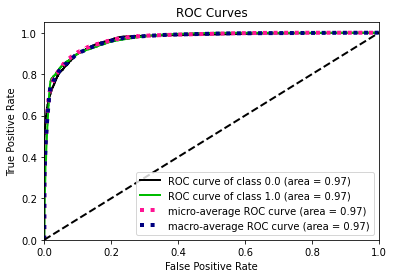

In [326]:
import scikitplot as skplt
skplt.metrics.plot_roc(predictions_df.pre_approved_le.values, list(predictions_df.probability));